<a href="https://colab.research.google.com/github/ArifAygun/Advanced-Pandas/blob/main/Graduate_Project_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time

import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import ensemble, metrics
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal=",").drop_duplicates()

Mounted at /content/drive/
/content/drive/My Drive/Flotation


In [3]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 75.83 Mb (46.0% reduction)


- The problem at hand appears to have a misalignment between the frequency of the features and the desired output, which is the percentage of Silica Concentrate (% Silica Concentrate). It is important to note that individual records do not predict the average % Silica Concentrate. Instead, it is the cumulative effect of all parameters over a period of time that results in the averaged % Silica Concentrate.

- From an industrial perspective, it is proposed to group and average all the records based on the % Silica Concentrate in order to address this issue. This approach can be perceived as a shortcut, but it aligns with the industrial understanding of the problem and provides a more meaningful analysis. By consolidating the data in this manner, we can capture the combined impact of various parameters on the averaged % Silica Concentrate.

In [4]:
# Grouping and averaging values by % Silica Concentrate
flotation_grpby = flotation.groupby(['% Silica Concentrate']).mean()

# Extracting % Silica Concentrate values
y = flotation_grpby.index.values.tolist()

# Removing % Iron Concentrate column as it is highly correlated with % Silica Concentrate (0.8)
flotation_grpby = flotation_grpby.drop(columns='% Iron Concentrate')

# Feature Scaling
min_max_scaler = MinMaxScaler()
flotation_scaled = min_max_scaler.fit_transform(flotation_grpby.values)
flotation_scaled = pd.DataFrame(flotation_scaled, columns=flotation_grpby.columns)

- Reducing dimensions is an effective approach to uncovering underlying variances.

In [5]:
# Dimensions reduction with Principal Components Analysis
pca = PCA(n_components=10)
flotation_pca = pca.fit_transform(flotation_scaled)

# Creation of the different datasets for training and testing
X_train, X_test, y_train, y_test = train_test_split(flotation_pca, y, test_size=0.3, random_state=42)

- Modelling

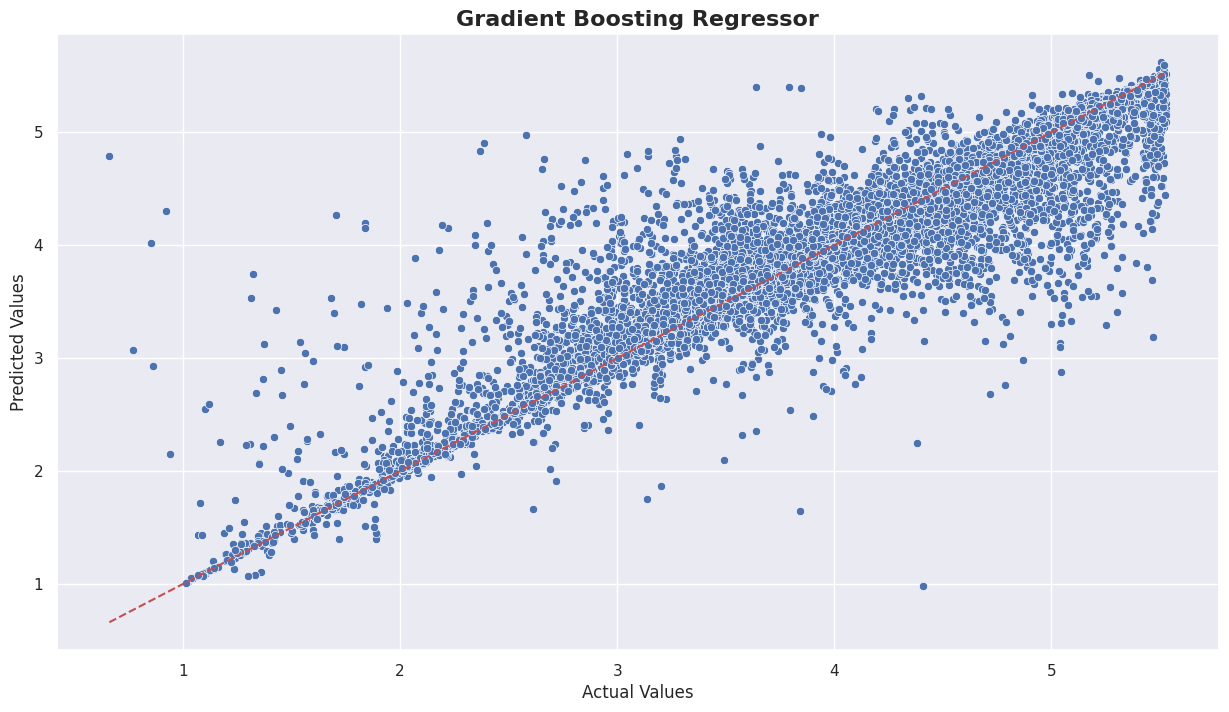

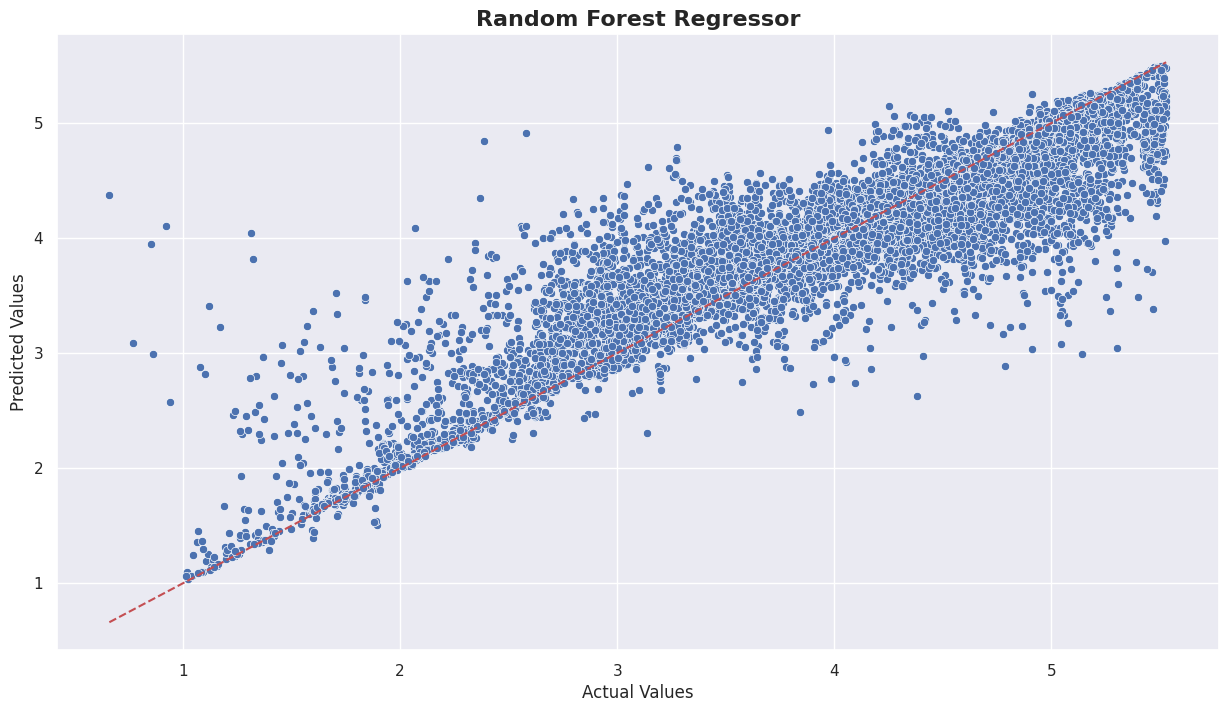

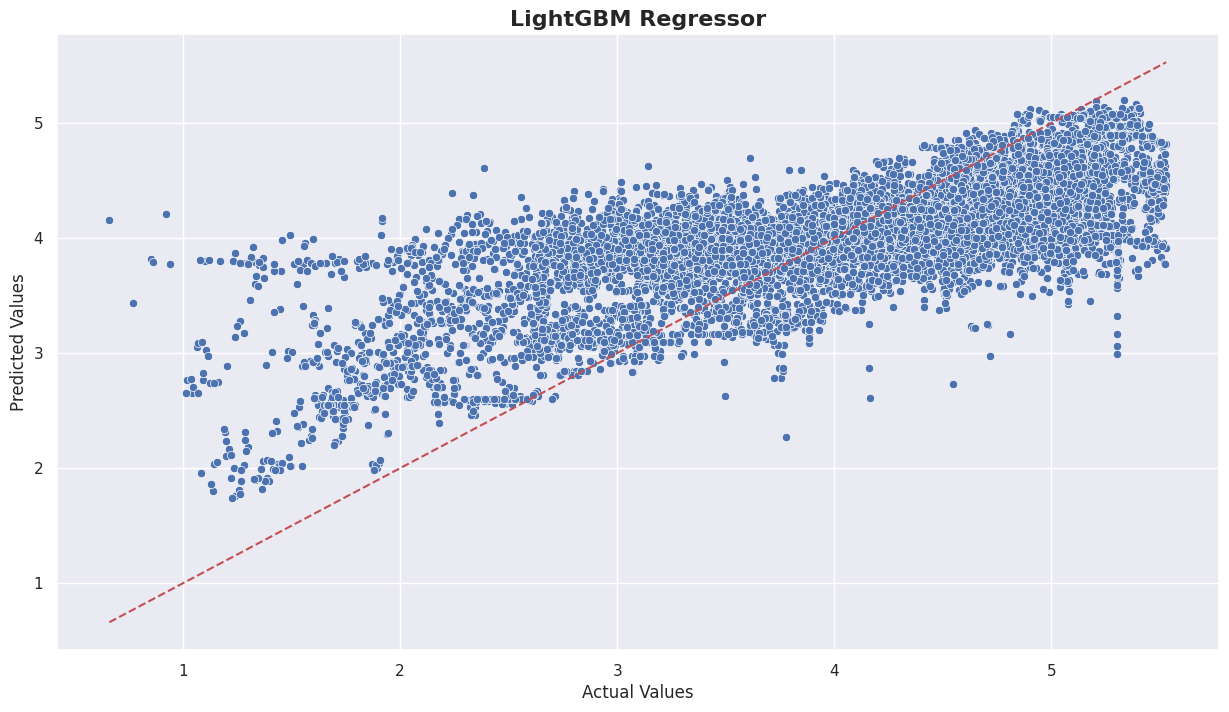

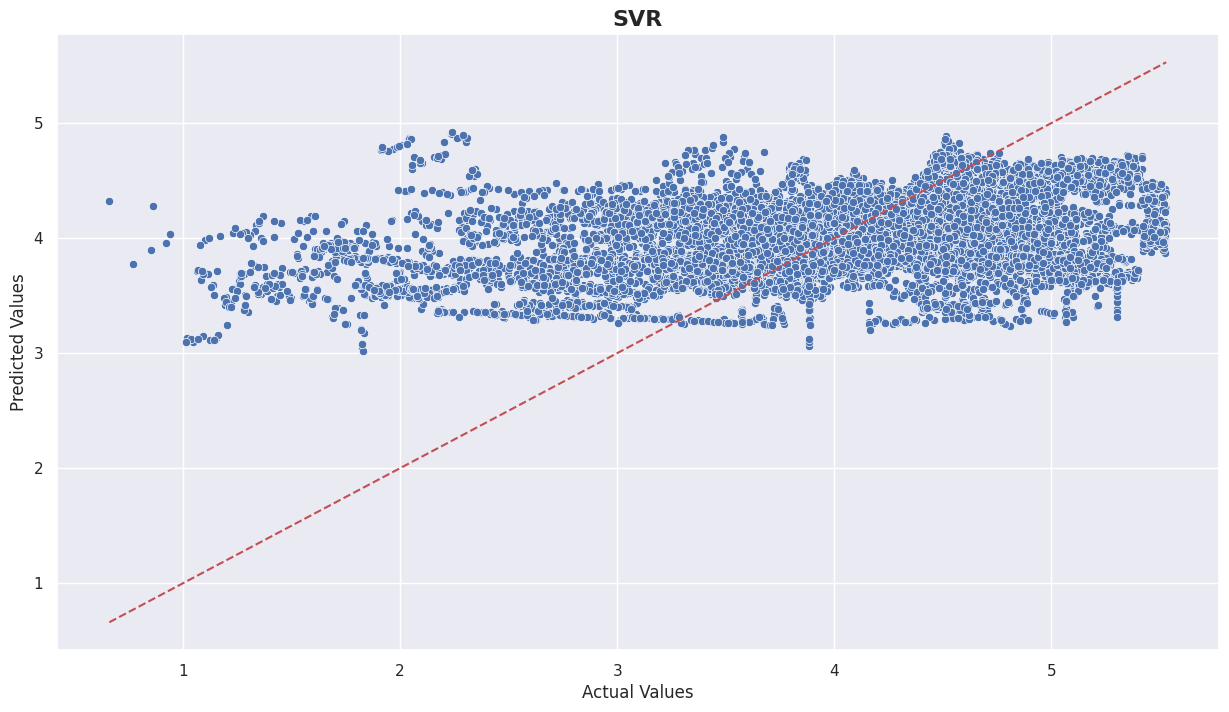

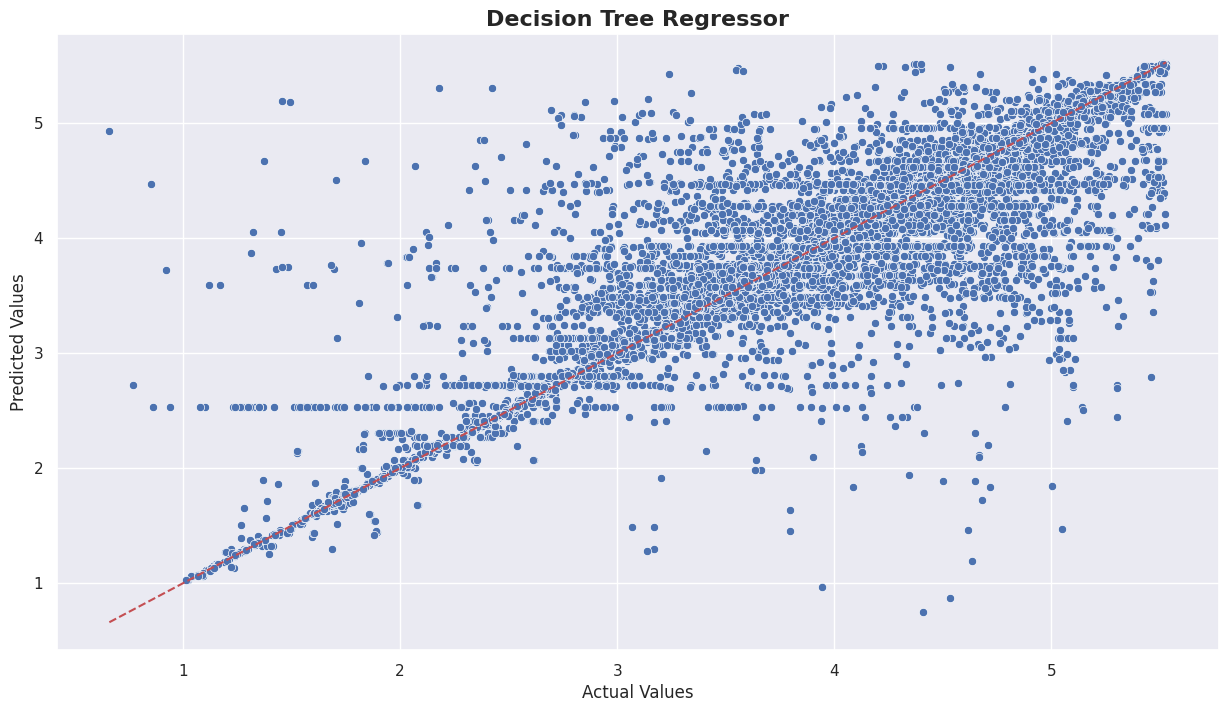

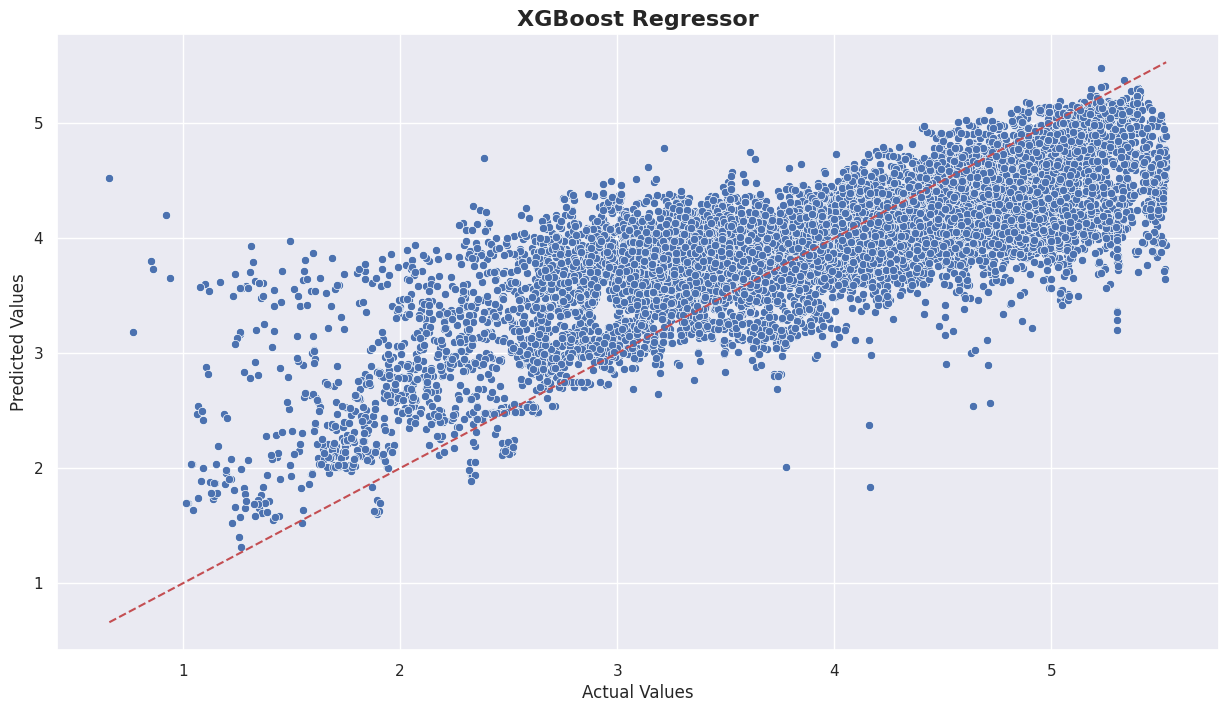

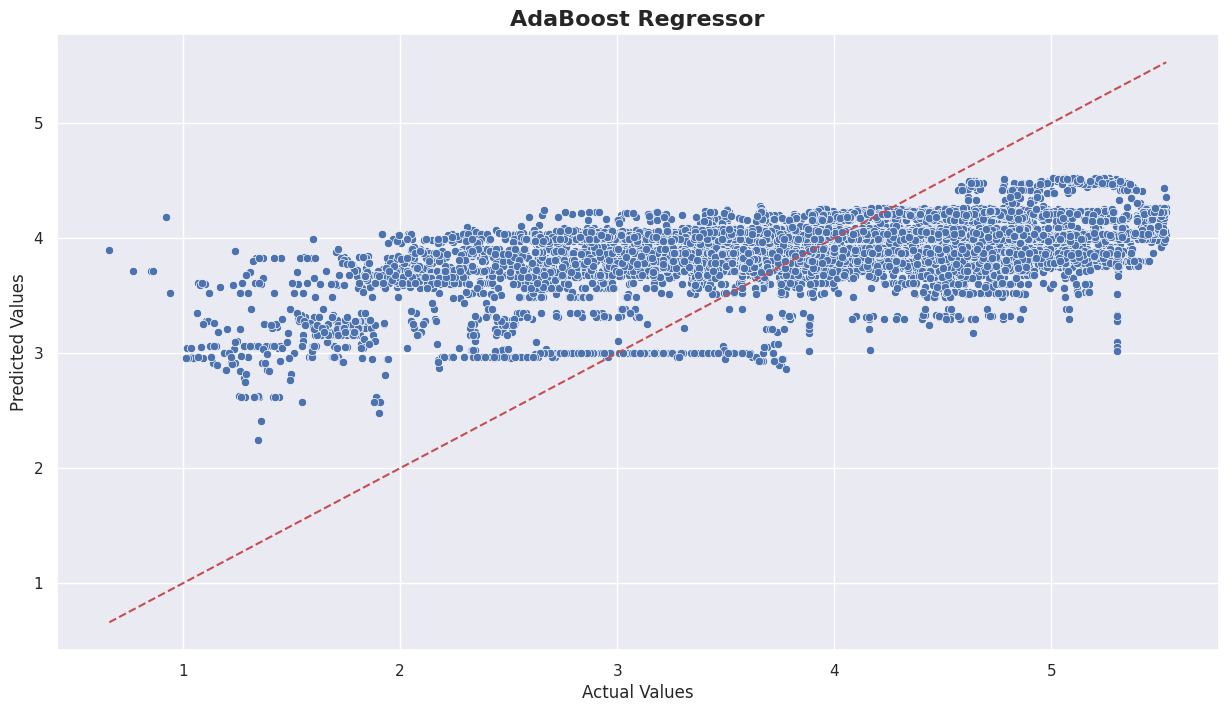

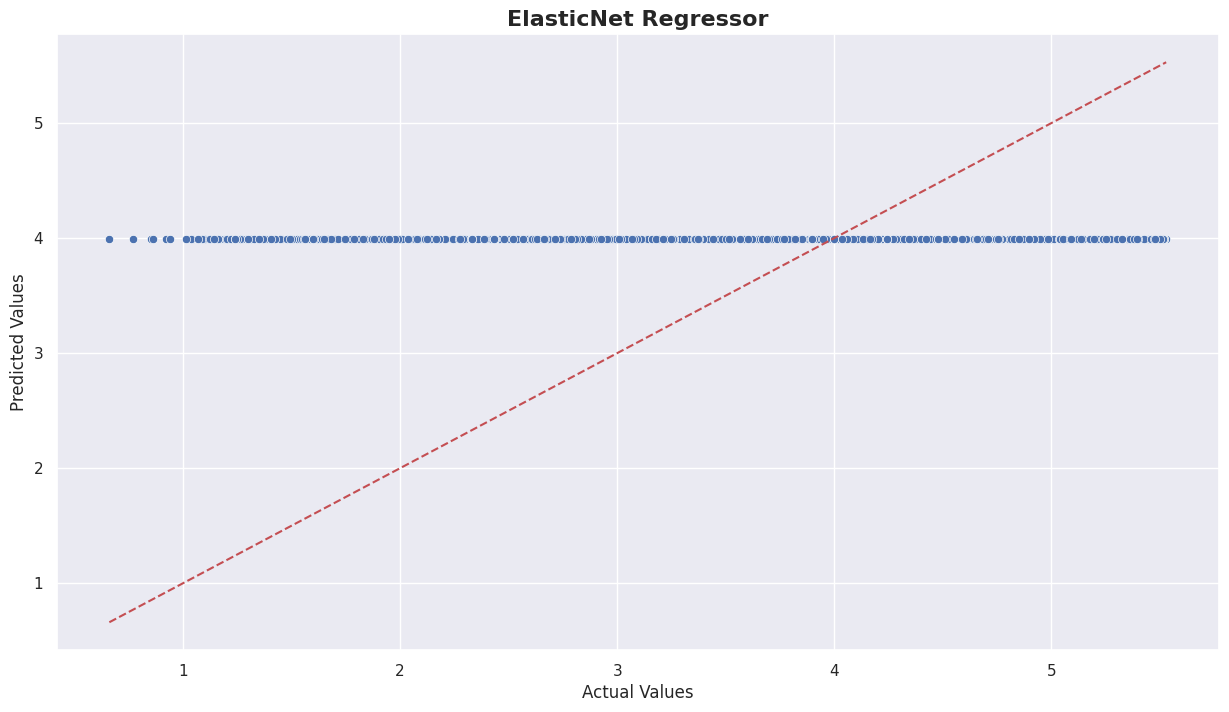

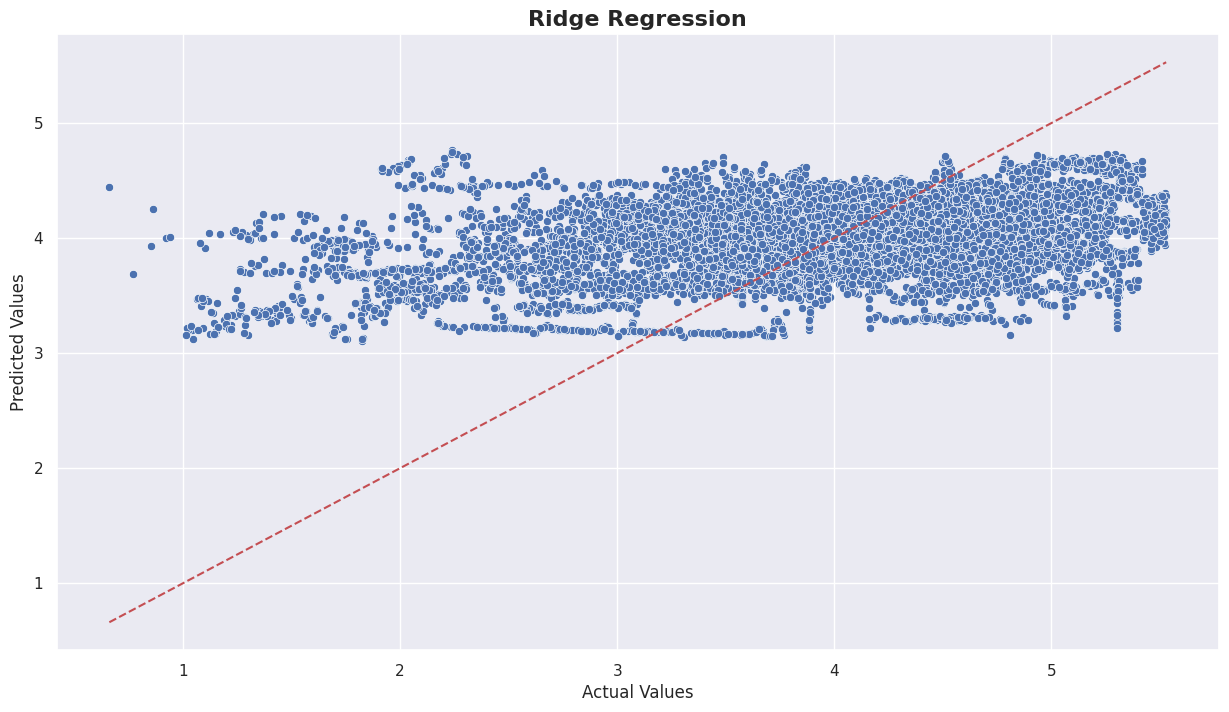

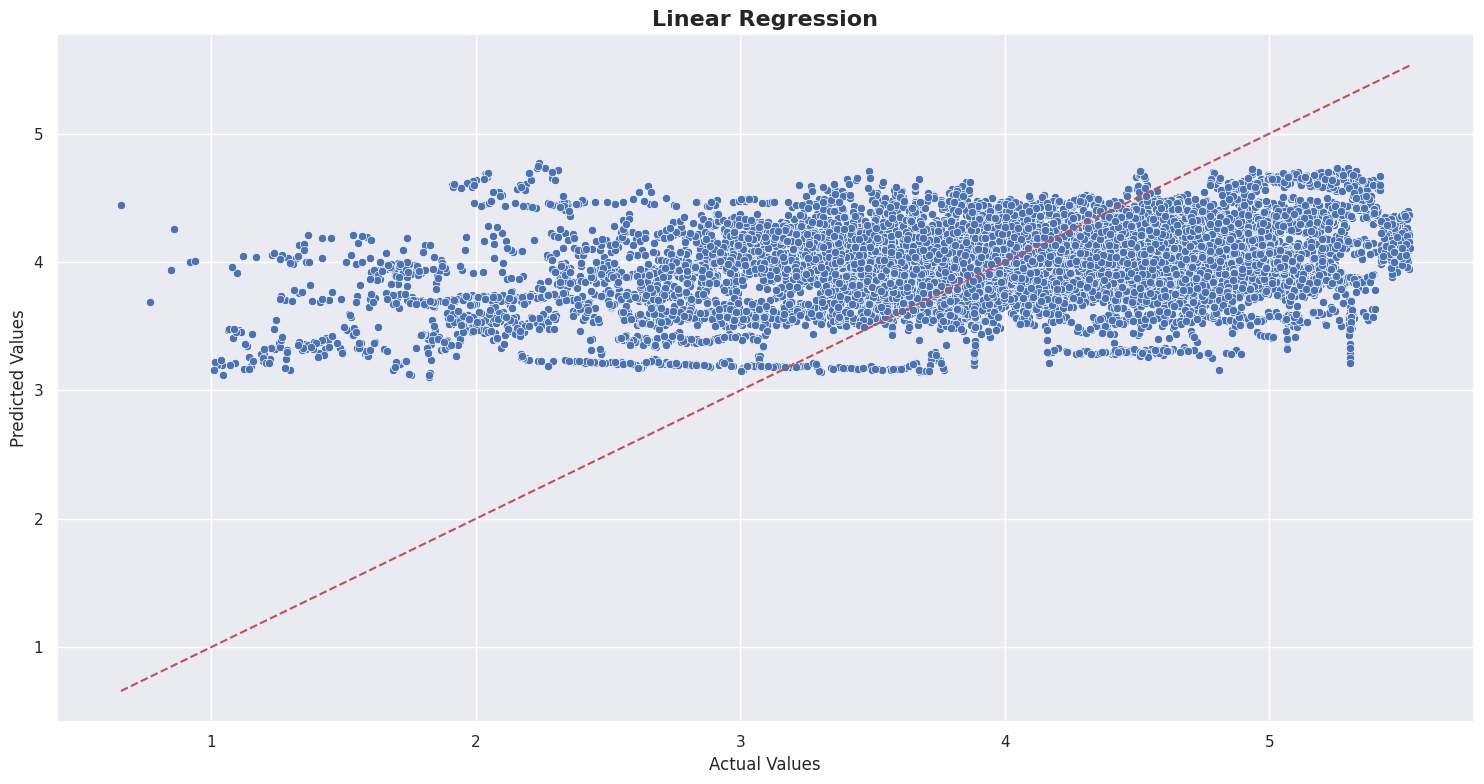

,Model,R-squared (Test dataset),MSE (Test dataset),Training Time,Inference Time
0,Gradient Boosting Regressor,0.870234,0.087941,123.514720,0.250244
1,Random Forest Regressor,0.843929,0.105768,74.647199,0.442751
2,LightGBM Regressor,0.485262,0.348833,2.538776,0.054457
3,SVR,0.090375,0.616444,72.691183,20.520355
4,Decision Tree Regressor,0.735433,0.179295,0.901824,0.004025
5,XGBoost Regressor,0.592050,0.276464,8.674196,0.022868
6,AdaBoost Regressor,0.186163,0.551529,20.821566,0.199147
7,ElasticNet Regressor,-0.000056,0.677728,0.018720,0.003740
8,Ridge Regression,0.110276,0.602957,0.035367,0.000722
9,Linear Regression,0.110274,0.602959,0.036095,0.000562


In [7]:
models = [
    {
        'name': 'Gradient Boosting Regressor',
        'model': ensemble.GradientBoostingRegressor(
            n_estimators=120,
            max_depth=16,
            learning_rate=0.1,
            criterion='squared_error'
        )
    },
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(
            n_estimators=120,
            max_depth=16,
            criterion='squared_error'
        )
    },
    {
        'name': 'LightGBM Regressor',
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05
        )
    },
    {
        'name': 'SVR',
        'model': SVR(kernel='linear')
    },
    {
        'name': 'Decision Tree Regressor',
        'model': DecisionTreeRegressor(
            max_depth=16,
            criterion='poisson'
        )
    },
    {
        'name': 'XGBoost Regressor',
        'model': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1
        )
    },
    {
        'name': 'AdaBoost Regressor',
        'model': AdaBoostRegressor(
            n_estimators=120,
            learning_rate=0.1,
            loss='linear'
        )
    },
    {
        'name': 'ElasticNet Regressor',
        'model': ElasticNet(
            alpha=0.5,
            l1_ratio=0.5
        )
    },
    {
        'name': 'Ridge Regression',
        'model': Ridge(
            alpha=0.5,
            solver='auto'
        )
    },
    {
        'name': 'Linear Regression',
        'model': LinearRegression()
    }
]

# Lists to store metric values and execution times
model_names = []
r_squared_values = []
mse_values = []
execution_times = []

for model in models:
    model_name = model['name']
    model_instance = model['model']

    # Model training
    start_time = time.time()
    model_instance.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Model performance on test data
    start_time = time.time()
    y_pred = model_instance.predict(X_test)
    inference_time = time.time() - start_time

    # Calculate metrics
    r_squared = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)

    # Append metric values and execution times
    model_names.append(model_name)
    r_squared_values.append(r_squared)
    mse_values.append(mse)
    execution_times.append({
        'Training Time': training_time,
        'Inference Time': inference_time
    })

    # Plotting predicted vs. actual values
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(model_name, fontsize=16, fontweight='bold')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

data = {
    'Model': model_names,
    'R-squared (Test dataset)': r_squared_values,
    'MSE (Test dataset)': mse_values,
    'Training Time': [t['Training Time'] for t in execution_times],
    'Inference Time': [t['Inference Time'] for t in execution_times]
    }

metrics_df = pd.DataFrame(data)
metrics_df

- Plot Evaluatuon Metrics

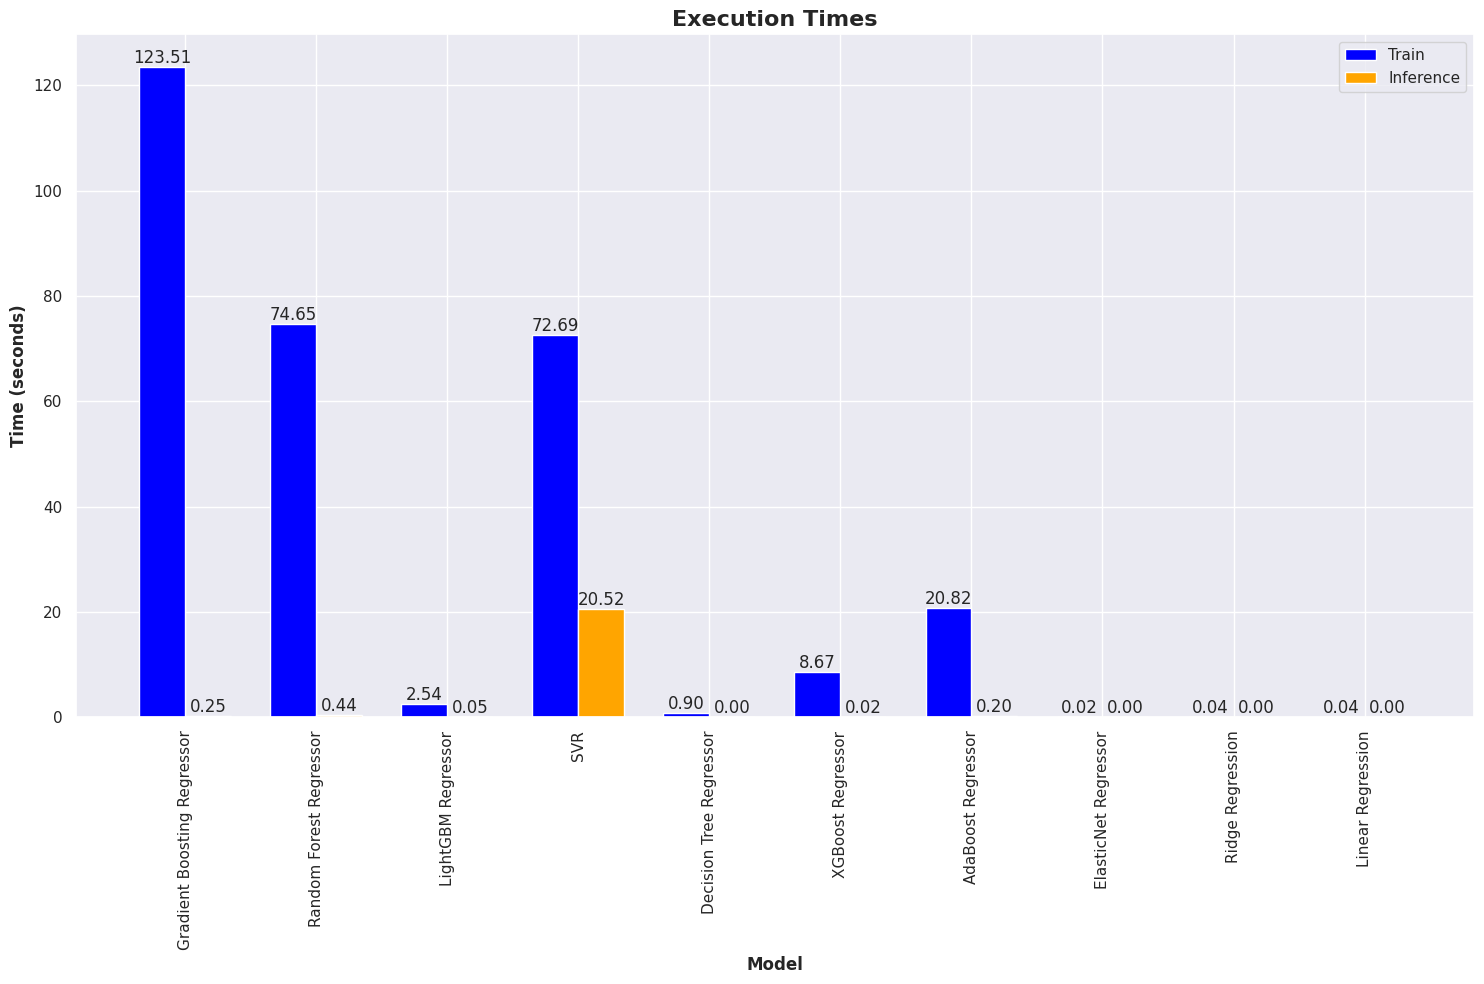

In [8]:
plt.figure(figsize=(15, 10))

execution_times_df = pd.DataFrame(execution_times, index=model_names)

bar_width = 0.35
index = range(len(model_names))

plt.bar(index, execution_times_df.iloc[:, 0], label='Train', color='blue', width=bar_width)
plt.bar([i + bar_width for i in index], execution_times_df.iloc[:, 1], label='Inference', color='orange', width=bar_width)

plt.title("Execution Times", fontsize=16, fontweight='bold')
plt.xlabel("Model", fontweight='bold')
plt.ylabel("Time (seconds)", fontweight='bold')
plt.xticks([i + bar_width/2 for i in index], model_names, rotation=90)
plt.legend()

# Add execution time labels
for i, row in enumerate(execution_times_df.iterrows()):
    model_name, execution_time = row
    plt.text(i, execution_time[0], f"{execution_time[0]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, execution_time[1], f"{execution_time[1]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


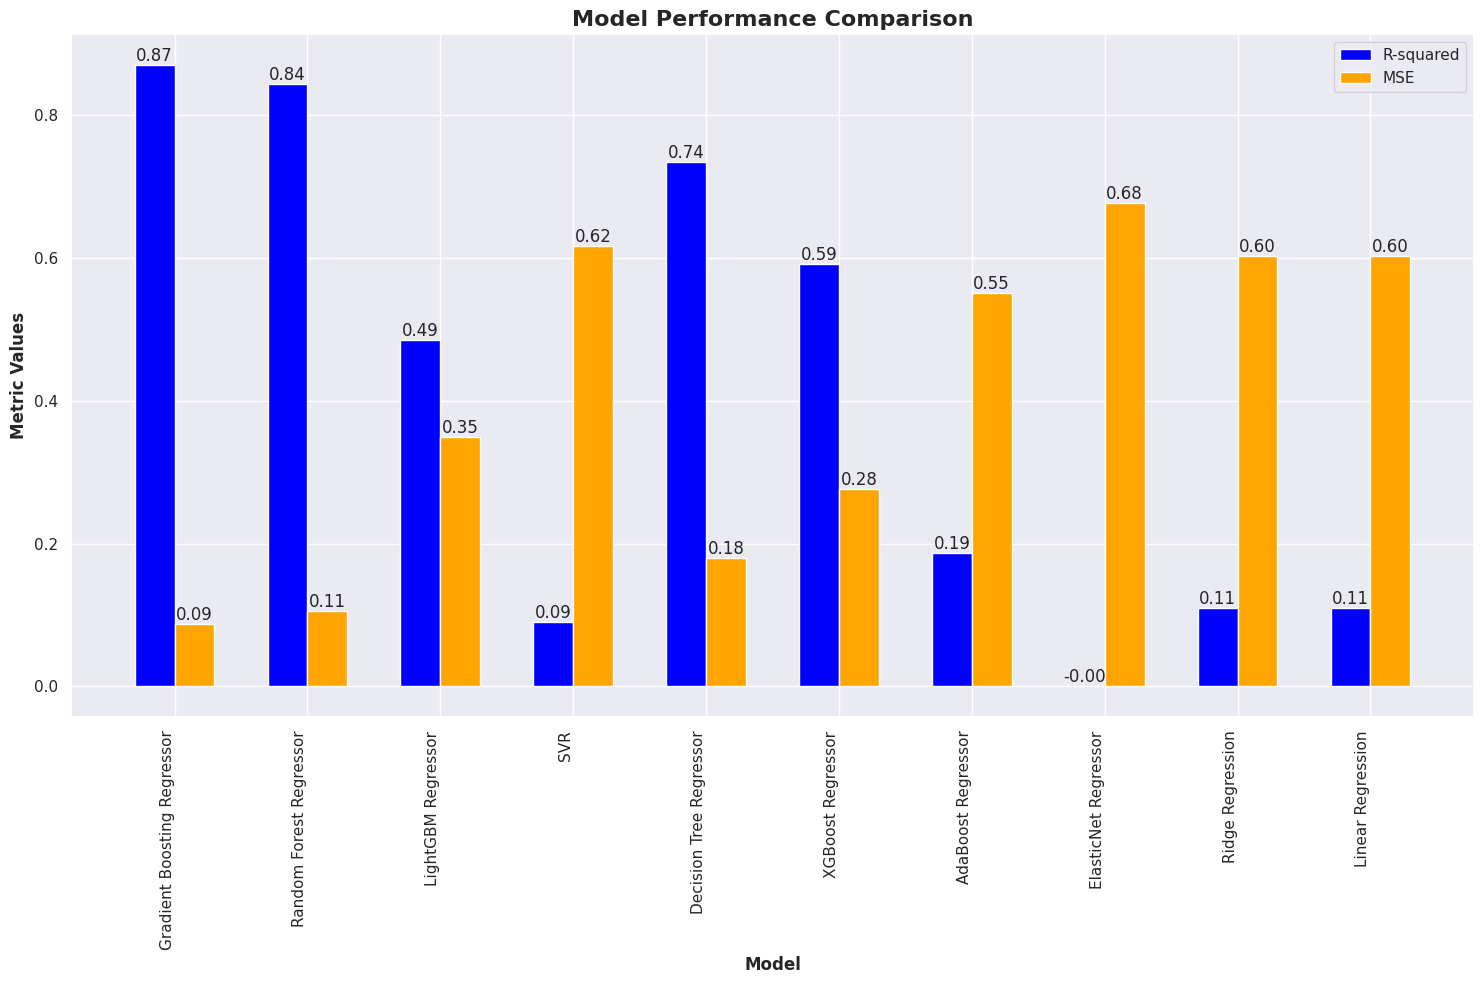

In [9]:
plt.figure(figsize=(15, 10))

bar_width = 0.30
index = np.arange(len(models))

plt.bar(index, r_squared_values, bar_width, label='R-squared', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

for i, value in enumerate(r_squared_values):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

for i, value in enumerate(mse_values):
    plt.text(i + bar_width, value, f"{value:.2f}", ha='center', va='bottom')

plt.xlabel("Model", fontweight='bold')
plt.ylabel("Metric Values", fontweight='bold')
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, model_names, rotation=90, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

Based on the results obtained from the different regression models, we can draw the following conclusions:

1. Gradient Boosting Regressor: The Gradient Boosting Regressor performed the best among all the models, achieving a high R-squared value of 0.87 and a relatively low mean squared error (MSE) of 0.0879. It had a longer training time of 123.51 seconds but had a fast inference time of 0.25 seconds.

2. Random Forest Regressor: The Random Forest Regressor also performed well with an R-squared value of 0.8439 and an MSE of 0.1058. It had a shorter training time compared to the Gradient Boosting Regressor (74.65 seconds) but a slightly longer inference time (0.44 seconds).

3. LightGBM Regressor: The LightGBM Regressor had a lower performance compared to the previous models, with an R-squared value of 0.4853 and a higher MSE of 0.3488. However, it had a significantly faster training time (2.54 seconds) and a very low inference time (0.054 seconds).

4. SVR: The Support Vector Regressor (SVR) had a relatively poor performance with an R-squared value of 0.0904 and a high MSE of 0.6164. It had a long training time of 72.69 seconds and a relatively high inference time of 20.52 seconds.

5. Decision Tree Regressor: The Decision Tree Regressor achieved an intermediate level of performance with an R-squared value of 0.7354 and an MSE of 0.1793. It had a very short training time of 0.90 seconds and an extremely low inference time of 0.004 seconds.

6. XGBoost Regressor: The XGBoost Regressor had a moderate performance with an R-squared value of 0.5921 and an MSE of 0.2765. It had a longer training time compared to some models (8.67 seconds) but a fast inference time of 0.022 seconds.

7. AdaBoost Regressor: The AdaBoost Regressor had a relatively poor performance with an R-squared value of 0.1862 and an MSE of 0.5515. It had a moderate training time of 20.82 seconds and an inference time of 0.199 seconds.

8. ElasticNet Regressor: The ElasticNet Regressor showed a very weak performance with an almost zero R-squared value (-0.000056) and a high MSE of 0.6777. It had a very short training time (0.0187 seconds) and an extremely low inference time (0.0037 seconds).

9. Ridge Regression: The Ridge Regression model performed poorly with an R-squared value of 0.1103 and an MSE of 0.6030. It had a short training time (0.035 seconds) and a very low inference time (0.0007 seconds).

10. Linear Regression: The Linear Regression model yielded results similar to the Ridge Regression model, with an R-squared value of 0.1103 and an MSE of 0.6030. It had similar training and inference times as the Ridge Regression model.

Overall, the Gradient Boosting Regressor and Random Forest Regressor demonstrated the best performance in terms of R-squared and MSE. The Decision Tree Regressor showed a good balance between performance and efficiency with very short training and inference times. On the other hand, models such as SVR, ElasticNet Regressor, AdaBoost Reg